In [1]:
# Import libraries as required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 10)

# Preparation for Logistic Regression


import os
import gc
import datetime
from numba import njit
from abc import abstractmethod, ABCMeta
from sklearn.kernel_approximation import Nystroem
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
# from cuml import LogisticRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.inspection import DecisionBoundaryDisplay
from tqdm.notebook import tqdm
from time import time

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics

# Parsing Urls
import re
from urllib.parse import urlparse
import os.path

# Turn the categories into numbers
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Models from Scikit-Learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

# Default settings of CSA Assessment 2
from collections import Counter
from timeit import timeit
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
df = pd.read_csv('./dga-24000.csv')
df

,Domain,Family
0,google.com,benign
1,facebook.com,benign
2,youtube.com,benign
3,twitter.com,benign
4,instagram.com,benign
...,...,...
23995,fhyibfwhpahb.su,locky
23996,nlgusntqeqixnqyo.org,locky
23997,awwduqqrjxttmn.su,locky
23998,ccxmwif.pl,locky


In [3]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["label"] = lb_make.fit_transform(df["Family"])
df["label"].value_counts()

label
1     1000
0     1000
12    1000
20    1000
17    1000
      ... 
19    1000
11    1000
22    1000
16    1000
5     1000
Name: count, Length: 24, dtype: int64

In [4]:
df_cp = df.copy()
df_cp

,Domain,Family,label
0,google.com,benign,1
1,facebook.com,benign,1
2,youtube.com,benign,1
3,twitter.com,benign,1
4,instagram.com,benign,1
...,...,...,...
23995,fhyibfwhpahb.su,locky,5
23996,nlgusntqeqixnqyo.org,locky,5
23997,awwduqqrjxttmn.su,locky,5
23998,ccxmwif.pl,locky,5


In [5]:
def url_length(url):
    return len(str(url))

df_cp['url_length'] = df_cp['Domain'].apply(lambda i: url_length(i))
df_cp

,Domain,Family,label,url_length
0,google.com,benign,1,10
1,facebook.com,benign,1,12
2,youtube.com,benign,1,11
3,twitter.com,benign,1,11
4,instagram.com,benign,1,13
...,...,...,...,...
23995,fhyibfwhpahb.su,locky,5,15
23996,nlgusntqeqixnqyo.org,locky,5,20
23997,awwduqqrjxttmn.su,locky,5,17
23998,ccxmwif.pl,locky,5,10


In [6]:
# Split into X & y and train/test
X = df_cp.drop("label", axis=1)
y = df_cp["label"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=5)
print(f"X_train Shape : {X_train.shape}")
print(f"Y_train Shape : {y_train.shape}")
print(f"X_test  Shape : {X_test.shape}")
print(f"Y_test  Shape : {y_test.shape}")

X_train Shape : (19200, 3)
Y_train Shape : (19200,)
X_test  Shape : (4800, 3)
Y_test  Shape : (4800,)


In [7]:
# 1. Import OneHotEncoder and ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# 2. Define the categorical features to transform
categorical_features = ["Domain", "Family"]

In [8]:
# 3. Create an instance of OneHotEncoder
one_hot = OneHotEncoder()

# 4. Create an instance of ColumnTransformer
transformer = ColumnTransformer([("one_hot", # name
                                  one_hot, # transformer
                                  categorical_features)], # columns to transform
                                  remainder="passthrough") # what to do with the rest of the columns? ("passthrough" = leave unchanged)

# 5. Turn the categorical features into numbers (this will return an array-like sparse matrix, not a DataFrame)
transformed_X = transformer.fit_transform(X)
transformed_X

<24000x24025 sparse matrix of type '<class 'numpy.float64'>'
	with 72000 stored elements in Compressed Sparse Row format>

In [9]:
X.head()

,Domain,Family,url_length
0,google.com,benign,10
1,facebook.com,benign,12
2,youtube.com,benign,11
3,twitter.com,benign,11
4,instagram.com,benign,13


In [10]:
# View first transformed sample
print(transformed_X[0])

  (0, 7962)	1.0
  (0, 24001)	1.0
  (0, 24024)	10.0


In [11]:
y

0        1
1        1
2        1
3        1
4        1
        ..
23995    5
23996    5
23997    5
23998    5
23999    5
Name: label, Length: 24000, dtype: int64

In [12]:
df_cp.head()

,Domain,Family,label,url_length
0,google.com,benign,1,10
1,facebook.com,benign,1,12
2,youtube.com,benign,1,11
3,twitter.com,benign,1,11
4,instagram.com,benign,1,13


In [13]:
categorical_variables = ["Domain", "Family", "url_length"]

dummies = pd.get_dummies(data=df_cp[categorical_variables])
dummies

,url_length,Domain_01ejk9ev8p2f.com,Domain_01u3cpy749eb.org,Domain_01ujw92vo9if.net,Domain_01yzkl67sta3.net,Domain_01yzo9mb45e7.org,Domain_02cew24e0q4m.net,Domain_02s6kmk20mkq.top,Domain_05mns9evgtqj.top,Domain_09mzctevk1yz.net,...,Family_ramnit,Family_ranbyus,Family_rovnix,Family_shifu,Family_shiotob,Family_simda,Family_suppobox,Family_symmi,Family_tinba,Family_virut
0,10,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,12,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,11,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,11,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,13,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,15,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23996,20,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23997,17,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
23998,10,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
# Have to convert labels to object for dummies to work on it.
df_cp["label"] = df_cp["label"].astype(object)
dummies = pd.get_dummies(data=df_cp[["Domain", "Family"]],
                         dtype=float)
dummies

,Domain_01ejk9ev8p2f.com,Domain_01u3cpy749eb.org,Domain_01ujw92vo9if.net,Domain_01yzkl67sta3.net,Domain_01yzo9mb45e7.org,Domain_02cew24e0q4m.net,Domain_02s6kmk20mkq.top,Domain_05mns9evgtqj.top,Domain_09mzctevk1yz.net,Domain_09uzgtiz4xa7.top,...,Family_ramnit,Family_ranbyus,Family_rovnix,Family_shifu,Family_shiotob,Family_simda,Family_suppobox,Family_symmi,Family_tinba,Family_virut
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Hyperparameter Tuning
Remember, if you're ever trying to tune a machine learning models hyperparameters and you're not sure where to start, you can always search something like "MODEL_NAME hyperparameter tuning".

In the case of LogisticRegression, you might come across articles, such as Hyperparameter Tuning Using Grid Search by Chris Albon.

The article uses GridSearchCV but we're going to be using RandomizedSearchCV.

The different hyperparameters to search over have been setup for you in log_reg_grid but feel free to change them.

In [15]:
np.random.seed(42)

# Create train and test splits with transformed_X
X_train, X_test, y_train, y_test = train_test_split(transformed_X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=38)

print(f"X_train.shape", X_train.shape)
print(f"X_test.shape", X_test.shape)
print(f"y_train.shape",y_train.shape)
print(f"y_test.shape", y_test.shape)


X_train.shape (16080, 24025)
X_test.shape (7920, 24025)
y_train.shape (16080,)
y_test.shape (7920,)


Since we've got a set of hyperparameters we can import RandomizedSearchCV, pass it our dictionary of hyperparameters and let it search for the best combination.

In [20]:
classifier1 = LogisticRegression(max_iter=1000, random_state=0)
classifier1.fit(X_train, y_train)
y_pred1 = classifier1.predict(X_test)

Time to use the predictions our model has made to evaluate it beyond accuracy.

In [21]:
# Create a confusion matrix using the confusion_matrix function
confusion_matrix(y_test, y_pred1)

array([[340,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 349,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 338,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 305,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 337,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 342,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 326,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0

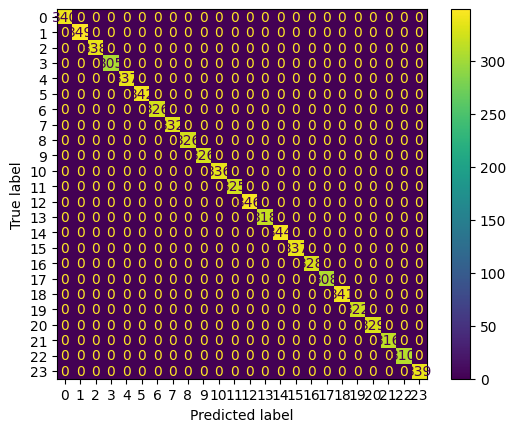

In [22]:
ConfusionMatrixDisplay.from_estimator(classifier1, X_test, y_test)
plt.show()

In [23]:
logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

LogisticRegression(C=100000.0)

In [24]:
logreg.score(X_train, y_train)

1.0

In [ ]:
from sklearn.model_selection import train_test_split , GridSearchCV, KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import metrics

In [ ]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, random_state=0)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean} ({stdev}) with: {param}")

In [ ]:
# we improve model by ذringing some features to the power of 3
# we have negative number so we can not use dim=2
dim = 3
for col in features.index.tolist()[1:]:
    new_col = f"{col}_{dim}"
    x[new_col] = x[col] ** dim
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(x_train, y_train)
    accuracy = metrics.accuracy_score(y_test, logreg.predict(x_test))
    if accuracy <= acc:
        x.drop(new_col, axis=1, inplace=True)
    else:
        acc = accuracy
        parameters = dict(solver='liblinear' ,penalty='l2',C=1)
        modeling(x, y, 0.2, ['Diabetes disease=1', 'Not Diabetes disease=0'], parameters, is_add=1)

In [ ]:
# classification report
print(classification_report(y_test, y_preds))

In [ ]:
# Plot a ROC curve using our current machine learning model using plot_roc_curve
plot_roc_curve(clf, X_test, y_test);